In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statsmodels.api as sm
from utils import ols_cir, plot_history

In [3]:
file_name = '../data/RC_F11_01_2010_T10_12_2021.csv'

In [4]:
df = pd.read_csv(file_name, delimiter=',', decimal='.')

In [5]:
df.columns = df.columns.str.strip()

In [6]:
df["Date"] = pd.to_datetime(df["DT"], format="%m/%d/%Y")
df = df.sort_values('Date').set_index('Date')

In [7]:
df = df['2019-01-01':'2021-12-10']

In [8]:
df['r'] = df['ruo'].values / 100

r = df['r'].values

dt = 1 / 252

print(f"✅ Данные загружены! Всего точек: {len(r)}")
print(f"Пример ставки (доли): {r[:5]}")

✅ Данные загружены! Всего точек: 719
Пример ставки (доли): [0.0759 0.0753 0.0753 0.0753 0.0753]


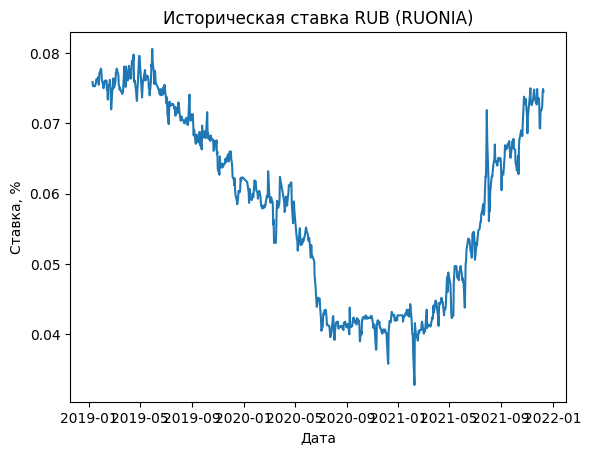

In [9]:
plot_history(df['r'], "Историческая ставка RUB (RUONIA)", "Ставка, %")

In [11]:
from utils import ols_cir

kappa, theta, sigma = ols_cir(r, dt)

In [12]:
print("\n=== 🎯 РЕЗУЛЬТАТЫ ДЛЯ RUONIA (RUB) ===")
print(f"Kappa: {kappa:.4f}")
print(f"Theta: {theta:.4f}")
print(f"Sigma: {sigma:.4f}")


=== 🎯 РЕЗУЛЬТАТЫ ДЛЯ RUONIA (RUB) ===
Kappa: 1.5179
Theta: 0.0582
Sigma: 0.0922


In [13]:
import numpy as np

def simulate_cir_paths(
    r0: float,
    kappa: float,
    theta: float,
    sigma: float,
    T: float,
    dt: float,
    n_paths: int,
    seed: int | None = None
):
    """
    Симуляция CIR-модели для одной валюты (RUB или USD).

    r0     - начальная ставка
    kappa  - скорость возврата к среднему
    theta  - долгосрочное среднее
    sigma  - волатильность
    T      - горизонт моделирования (в годах)
    dt     - шаг по времени (в годах)
    n_paths - количество сценариев
    """
    if seed is not None:
        np.random.seed(seed)

    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps + 1))
    rates[:, 0] = r0

    for t in range(n_steps):
        Z = np.random.normal(size=n_paths)
        r_t = rates[:, t]
        # full truncation, чтобы избежать отрицательных ставок
        sqrt_r = np.sqrt(np.maximum(r_t, 0.0))
        dr = kappa * (theta - r_t) * dt + sigma * sqrt_r * np.sqrt(dt) * Z
        rates[:, t + 1] = r_t + dr
        # по желанию можно ещё обнулить отрицательные значения:
        rates[:, t + 1] = np.maximum(rates[:, t + 1], 0.0)

    return rates

In [14]:
from utils import simulate_cir_paths

r0_rub = r[0]

rates_rub = simulate_cir_paths(
    r0=r0_rub,
    kappa=kappa,
    theta=theta,
    sigma=sigma,
    T=1.0,
    dt=dt,
    n_paths=10000,
)

In [15]:
rates_rub

array([[0.0759    , 0.07658834, 0.0753864 , ..., 0.08338267, 0.08245125,
        0.08389495],
       [0.0759    , 0.07557189, 0.07497912, ..., 0.07005413, 0.07160475,
        0.07142044],
       [0.0759    , 0.07683002, 0.07575553, ..., 0.06090066, 0.0613395 ,
        0.05881523],
       ...,
       [0.0759    , 0.07466418, 0.07516555, ..., 0.05882992, 0.06098656,
        0.06289369],
       [0.0759    , 0.07658682, 0.07923124, ..., 0.03644966, 0.03699607,
        0.03866872],
       [0.0759    , 0.07682473, 0.07410353, ..., 0.05804703, 0.05716057,
        0.05742693]], shape=(10000, 253))